In [41]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import os
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pysal.model import mgwr
from scipy.stats import pearsonr
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from urbana.models.plot_predictions import PredictedAccuracy
from urbana.constants import DIR_REPO, DIR_DATA

SCL_PATH = DIR_DATA / "external" / "scl"
CENSUS_PATH = SCL_PATH / "census"
URBAN_AREAS_PATH = SCL_PATH / "urban_areas"
URBAN_DISTRICTS_PATH = SCL_PATH / "urban_districts"
PATH_R13 = SCL_PATH / "R13"

In [44]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

OUTPUT_WARNINGS = False
SAVE_FIGS = True
FIT_INTERCEPT = True

VARIABLE_TO_PREDICT = "Airbnb_Count"

In [45]:
if OUTPUT_WARNINGS is False:
    import warnings

    warnings.filterwarnings("ignore")

# Parameter Check

In [54]:
# Create folders to store the data
DIR_VAR = SCL_PATH / "output/{}".format(VARIABLE_TO_PREDICT)
DIR_GWR = DIR_VAR / "02_gwr"

if SAVE_FIGS:
    folder_list = [
        DIR_GWR,
        DIR_GWR / "coefficients",
    ]

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

# Initial visualizations

In [47]:
sect = pd.read_csv(SCL_PATH / "output/census_processed.csv")

sect.drop(
    [
        "REGION",
        "PROVINCIA",
        "COMUNA",
        "COD_DISTRI",
        "DESC_REGIO",
        "DESC_PROVI",
        "DESC_COMUN",
        "DESC_DISTR",
    ],
    axis=1,
    inplace=True,
)

sect = sect.loc[:, ~sect.columns.str.contains("^Unnamed")]

# sect.drop(
#     ["N_district", "N_neighbourhood", "N_section"],
#     axis=1,
#     inplace=True,
# )


sect.isnull().sum(axis=0).sort_values(ascending=False).head(10)

geometry                   0
Distance_Center            0
Airbnb_Per_Person_Price    0
Airbnb_Price               0
Airbnb_Count               0
total_pois                 0
museum_pois_count          0
tourism_pois_count         0
shop_pois_count            0
religion_pois_count        0
dtype: int64

In [48]:
geo_info = gpd.read_file(URBAN_DISTRICTS_PATH)

geo_coefs = geo_info.copy()
geo_tvals = geo_info.copy()
geo_nans = geo_info.copy()

In [49]:
y = np.array(sect[VARIABLE_TO_PREDICT]).reshape((-1, 1))
X = sect.drop(
    [
        "Airbnb_Count",
        "Airbnb_Price",
        "Airbnb_Per_Person_Price",
        "Airbnb_Location_Rating",
    ],
    axis=1,
)
coords = np.column_stack(
    [geo_info["geometry"].centroid.x, geo_info["geometry"].centroid.y]
)

geo_info["centroid"] = geo_info["geometry"].centroid

In [50]:
geo_info[VARIABLE_TO_PREDICT] = sect[VARIABLE_TO_PREDICT]

id_max_airbnb = geo_info[VARIABLE_TO_PREDICT].idxmax()

print("Area with maximum value: " + str(id_max_airbnb))

Area with maximum value: 216


# Target variable

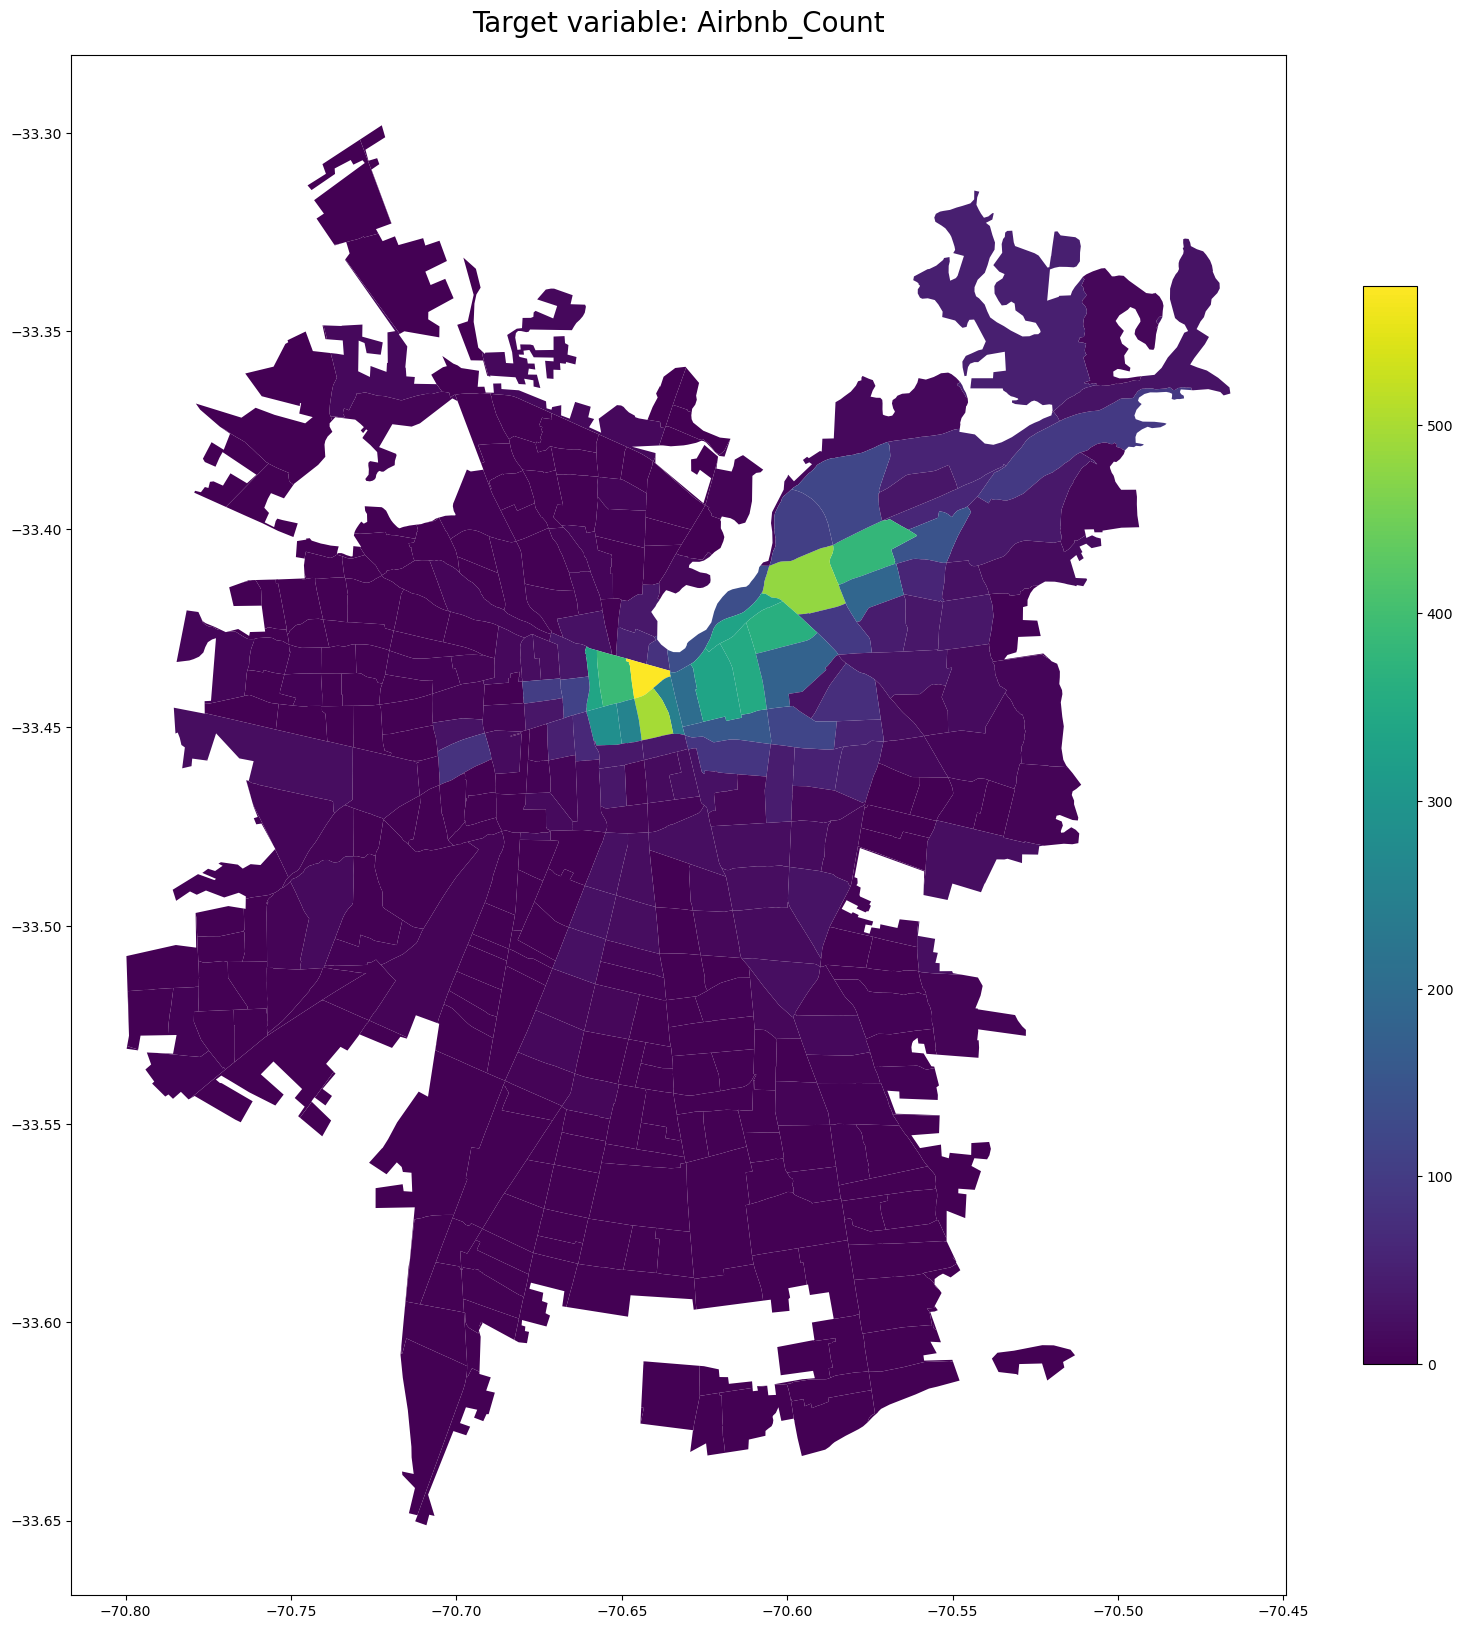

In [51]:
fig, ax = plt.subplots(figsize=(20, 20))

geo_info.plot(
    ax=ax,
    column=VARIABLE_TO_PREDICT,
    legend=True,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Target variable: " + str(VARIABLE_TO_PREDICT), fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_GWR / "target_variable.svg", format="svg")

plt.show()

# Nans (previusly filled with 0's)

In [52]:
# define the colormap
cmap = plt.cm.Accent_r
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
# cmaplist[0] = (0.5, 0.5, 0.5, 1.0)
cmaplist[0] = "0.8"
# define the bins and normalize
bounds = np.linspace(0, 8, 9)
my_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

my_cmap = mpl.colors.LinearSegmentedColormap.from_list("Custom cmap", cmaplist, cmap.N)

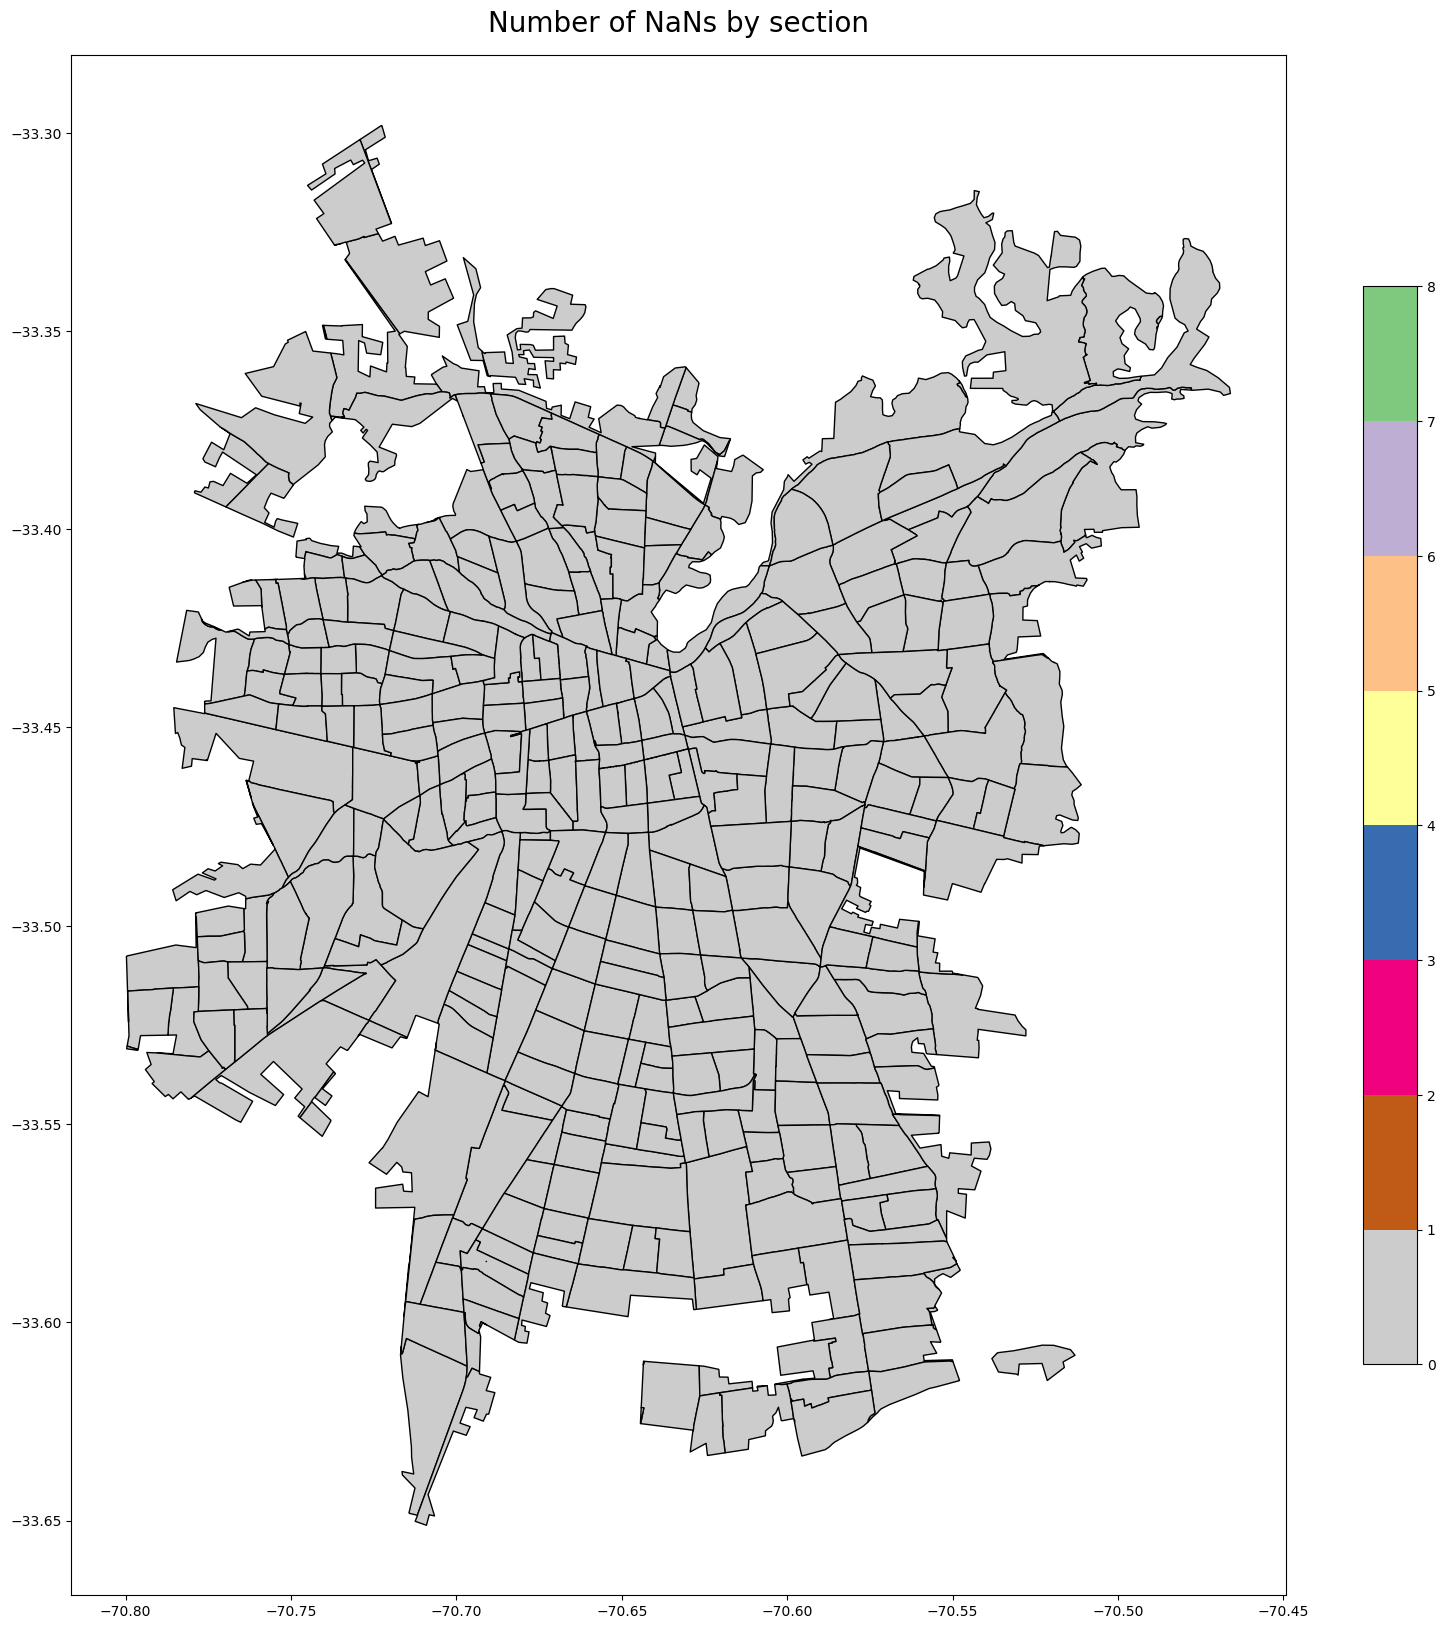

In [53]:
geo_nans["NaNs"] = pd.isnull(sect).sum(axis=1)

fig, ax = plt.subplots(figsize=(20, 20))

geo_nans.plot(
    ax=ax,
    column="NaNs",
    edgecolor="black",
    legend=True,
    norm=my_norm,
    cmap=my_cmap,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Number of NaNs by section", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_GWR / "nans.svg", format="svg")

plt.show()

# GWR

### Load best model (frome notebook "12_census_linear.ipynb")